In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

In [18]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Part 1 
### Data cleaning

In [19]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
# test_data = pd.read_csv("test.csv")
train_data.set_index('PassengerId',inplace = True)
# test_data.set_index('PassengerId',inplace = True)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [21]:
null_values = train_data.isna().sum()
print(null_values)

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


Cabin is mostly NaN.  That isn't going to be useful.  Getting rid of that column.  Age also has a lot of missing values; however, that is something that we can impute.

In [22]:
train_data.drop('Cabin', axis = 1, inplace = True)
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S


In [23]:
age_class_relationship = train_data.groupby('Pclass')['Age'].mean()
print(age_class_relationship)

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64


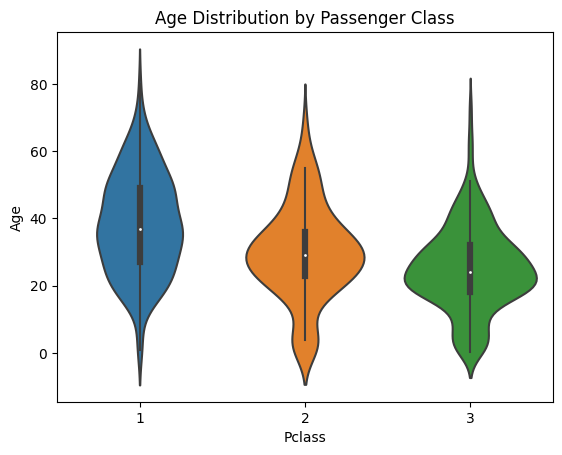

In [24]:
sns.violinplot(x='Pclass', y='Age', data=train_data)
plt.title('Age Distribution by Passenger Class')
plt.show()

We can use this to estimate the missing age values.

In [25]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

train_data['Age'] = imputer.fit_transform(train_data[['Age']])

In [26]:
def impute_vals(cols):
	Age = cols[0]
	Pclass = cols[1]
	
	if pd.isnull(Age):
		return age_class_relationship[Pclass]
	else:
		return Age

train_data['Age'] = train_data[['Age', 'Pclass']].apply(lambda ser: impute_vals([ser.iloc[0], ser.iloc[1]]), axis=1)
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S


In [27]:
null_values = train_data.isna().sum()
print(null_values)

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
dtype: int64


In [28]:
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode().iloc[0])

In [29]:
null_values = train_data.isna().sum()
print(null_values)

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64


Now that we've cleaned our data, let's see what we've got.

# Part 2
### EDA

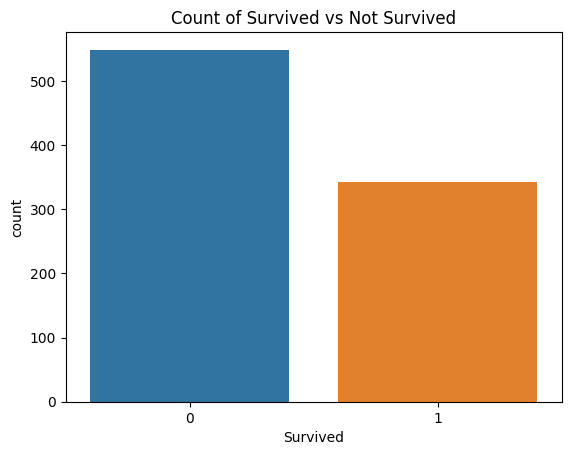

In [30]:
sns.countplot(x='Survived', data=train_data)
plt.title('Count of Survived vs Not Survived')
plt.show()

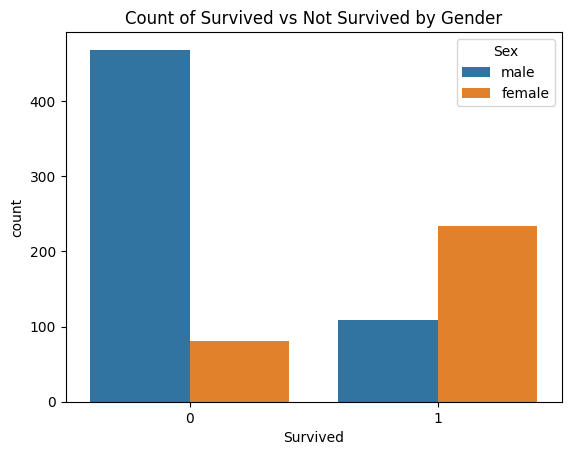

In [31]:
sns.countplot(x='Survived', hue='Sex', data=train_data)
plt.title('Count of Survived vs Not Survived by Gender')
plt.show()

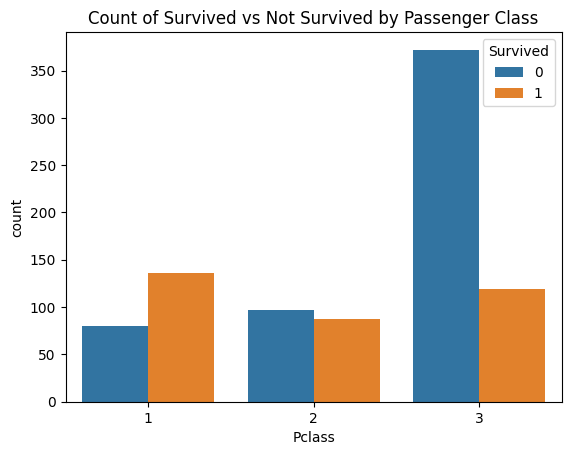

In [32]:
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('Count of Survived vs Not Survived by Passenger Class')
plt.show()

In [33]:
passenger_count_by_class = train_data['Pclass'].value_counts()
print(passenger_count_by_class)

Pclass
3    491
1    216
2    184
Name: count, dtype: int64


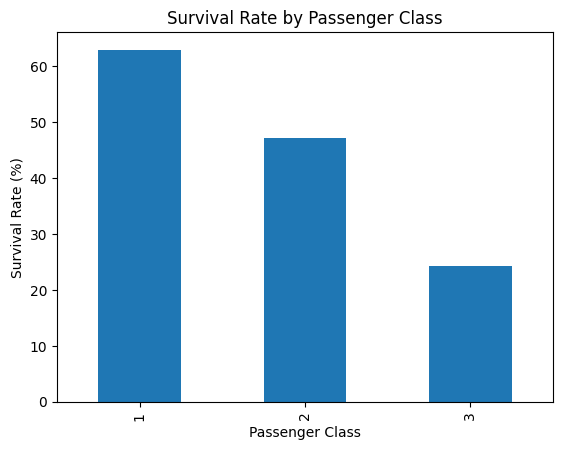

In [34]:
# Calculate the survival rate by passenger class
survival_rate_by_pclass = train_data.groupby('Pclass')['Survived'].mean() * 100

# Plot the survival rate by passenger class
survival_rate_by_pclass.plot(kind='bar')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate (%)')
plt.show()

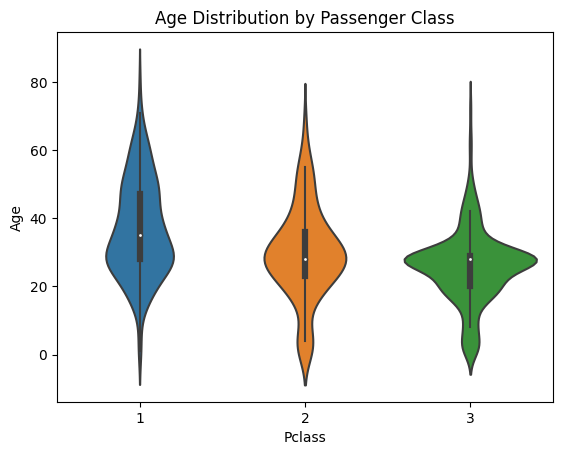

In [35]:
sns.violinplot(x='Pclass', y='Age', data=train_data)
plt.title('Age Distribution by Passenger Class')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

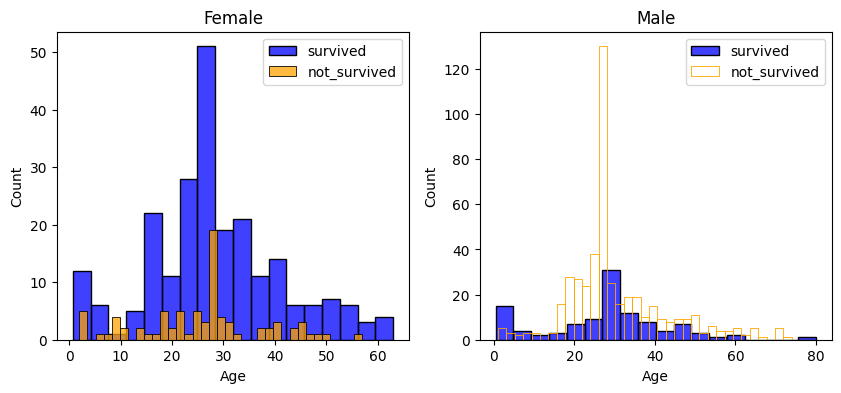

In [36]:
# Now let's show the number of survived passengers by Sex and Age:

women = train_data[train_data['Sex'] == 'female']
men = train_data[train_data['Sex'] == 'male']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  # To display two plots side-by-side

ax = sns.histplot(women[women['Survived'] == 1].Age, bins=18, label='survived', ax=axes[0], color='blue')
ax = sns.histplot(women[women['Survived'] == 0].Age, bins=35, label='not_survived', ax=axes[0], color='orange')
ax.legend()
ax.set_title('Female')

ax = sns.histplot(men[men['Survived'] == 1].Age, bins=18, label='survived', ax=axes[1], color='blue')
ax = sns.histplot(men[men['Survived'] == 0].Age, bins=35, label='not_survived', ax=axes[1], color='orange', fill=False)
ax.legend()
ax.set_title('Male')

plt.show()

# Part 3

It is time to clean the data in preparation for logistic regression

In [37]:
# Encode 'Sex' and 'Embarked' columns
sex = pd.get_dummies(train_data['Sex'], drop_first=True)
embark = pd.get_dummies(train_data['Embarked'], drop_first=True)

# Drop the original 'Sex', 'Embarked', 'Name', and 'Ticket' columns
train_data.drop(['Sex', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

# Concatenate the encoded columns with the train_data dataframe
train_data = pd.concat([train_data, sex, embark], axis=1)

train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,True,False,True
2,1,1,38.0,1,0,71.2833,False,False,False
3,1,3,26.0,0,0,7.9250,False,False,True
4,1,1,35.0,1,0,53.1000,False,False,True
5,0,3,35.0,0,0,8.0500,True,False,True


In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   male      891 non-null    bool   
 7   Q         891 non-null    bool   
 8   S         891 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 51.3 KB


In [39]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('Survived', axis=1), train_data['Survived'], test_size=0.33, random_state=101)

In [40]:
logmodel = LogisticRegression(max_iter=1000)

# Fit the model
logmodel.fit(X_train, y_train)

# Predict the survived passengers
predictions = logmodel.predict(X_test)

In [41]:
print("Accuracy:", accuracy_score(y_test, predictions))

Accuracy: 0.7966101694915254


In [42]:
lr = LogisticRegression(max_iter=1000)
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.78333333 0.83333333 0.71666667 0.9        0.76666667 0.75
 0.86440678 0.83050847 0.77966102 0.86440678]
Mean: 0.8088983050847457
Standard Deviation: 0.05549193986134522


In [43]:
lr = LogisticRegression(max_iter=1000)
predictions = cross_val_predict(lr, X_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

array([[331,  49],
       [ 71, 145]])

In [44]:

print("Precision:", precision_score(y_test, logmodel.predict(X_test)))
print("Recall:", recall_score(y_test, logmodel.predict(X_test)))

Precision: 0.8113207547169812
Recall: 0.6825396825396826


In [45]:
f1_score(y_train, predictions)

0.7073170731707317